In [1]:
import torch
import numpy as np
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm
from train import Agent
from pathos.multiprocessing import ProcessingPool as Pool

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\navid\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
# To enable parallel processing for increasing the training speed
def parallelied_run(params):
    from train import Agent
    agent = Agent(**params)
    return agent.train()

### Exepriment 1: Prioritized Replay 

In [14]:
# running different hyperparameters of prioritized experience replay


parameters_prioritized = {
        "gamma": 0.99,
        "lr": 5e-4,
        "TAU": 0.01,
        "episode_num": 490,
        "batch_size": 64,
        "epsilon_max": 0.1,
        "epsilon_min": 0.02,
        "device": "cpu",
        "env_name": "CartPole-v1",
        "buffer_type": "prioritized",
        "buffer_size": 50_000,
        # "buffer_alpha": 0.7, # this is chosen as hyper-parameter
        # "buffer_beta": 0.2, # this is chosen as hyper-parameter
        }

# we run 9 configs of this algorithm and find the best ones. We consider our hyperparameters to be alpha and beta.
alpha = [0.6, 0.7, 0.8]
beta = [0.3, 0.5, 0.7] 
hyper_parameters = []
parameters_parallel_prioritized = []
for al in alpha:
    for bet in beta:
        parameters = parameters_prioritized.copy()
        parameters["buffer_alpha"] = al
        parameters["buffer_beta"] = bet
        hyper_parameters.append((al,bet))
        parameters_parallel_prioritized += [parameters for _ in range(10)]

#parallel processing
with Pool() as p:
    parameters_parallel_prioritized
    return_data = p.map(parallelied_run, parameters_parallel_prioritized)

return_data_np = np.array(return_data)
np.save("experiment_1_v1_prioritized_final",return_data_np)

### Exepriment 1: Random Replay 

In [9]:
# running random experience replay


parameters_random = {
        "gamma": 0.99,
        "lr": 5e-4,
        "TAU": 0.01,
        "episode_num": 490,
        "batch_size": 64,
        "epsilon_max": 0.1,
        "epsilon_min": 0.02,
        "device": "cpu",
        "env_name": "CartPole-v1",
        "buffer_type": "random",
        "buffer_size": 50_000,
        }


parameters_parallel_random = [parameters_random for _ in range(10)]
#parallel processing
with Pool() as p:
    return_data_random = p.map(parallelied_run, parameters_parallel_random)

return_data_np_random = np.array(return_data_random)
np.save("experiment_1_v1_random_final",return_data_np_random)

### Reploading the Data and Drawing Graphs

In [3]:
return_data_np_random = np.load("experiment_data/experiment 1 data/experiment_1_v1_random_final.npy")
return_data_np_prioritized = np.load("experiment_data/experiment 1 data/experiment_1_v1_prioritized_final.npy")

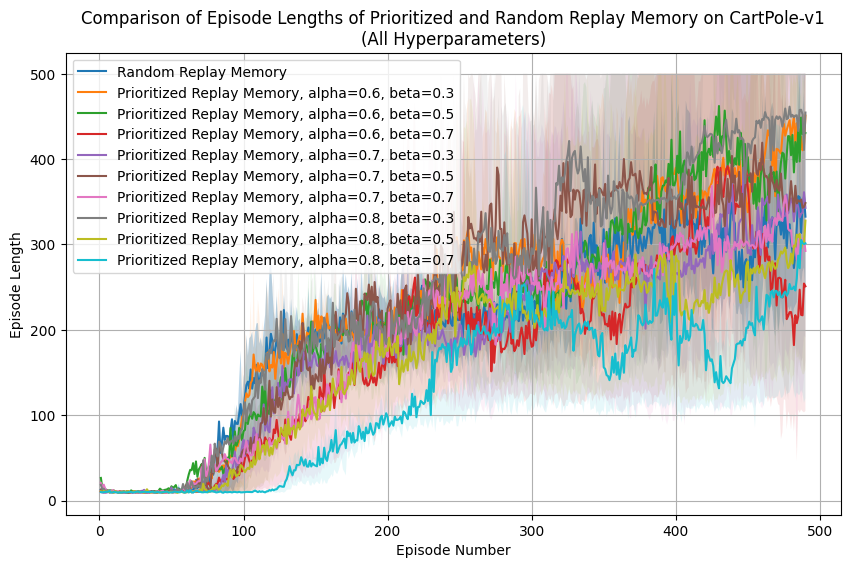

In [5]:
import numpy as np
import matplotlib.pyplot as plt

num_runs = 10
num_episodes = 490
indx = {"episode_len":0, "loss":1, "discounted_return":2}
algorithm_rewards_random = return_data_np_random[0:num_runs,indx["episode_len"]]
algorithm_rewards_prioritized = [return_data_np_prioritized[i*num_runs:(i+1)*num_runs,indx["episode_len"]] for i in range(9)]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), np.mean(algorithm_rewards_random,axis=0), label='Random Replay Memory')
lower_quantile = np.percentile(algorithm_rewards_random, 25, axis=0)
upper_quantile = np.percentile(algorithm_rewards_random, 75, axis=0)
plt.fill_between(range(1, num_episodes + 1), lower_quantile, upper_quantile, alpha=0.3)
for i in range(9):
    plt.plot(range(1, num_episodes + 1), np.mean(algorithm_rewards_prioritized[i],axis=0), label=f'Prioritized Replay Memory, alpha={hyper_parameters[i][0]}, beta={hyper_parameters[i][1]}')
    lower_quantile = np.percentile(algorithm_rewards_prioritized[i], 25, axis=0)
    upper_quantile = np.percentile(algorithm_rewards_prioritized[i], 75, axis=0)
    plt.fill_between(range(1, num_episodes + 1), lower_quantile, upper_quantile, alpha=0.1)

plt.xlabel('Episode Number')
plt.ylabel('Episode Length')
plt.title('Comparison of Episode Lengths of Prioritized and Random Replay Memory on CartPole-v1\n(All Hyperparameters)')
plt.legend()
plt.grid(True)
plt.show()


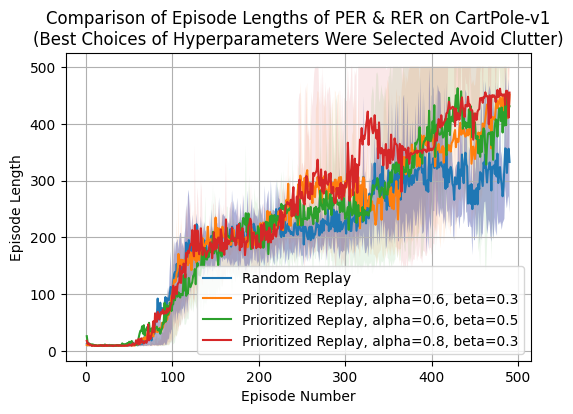

In [11]:
# grpah showing hand-picked hyper-parameters of prioritized memory for comparison with random replay memory
import numpy as np
import matplotlib.pyplot as plt

num_runs = 10
num_episodes = 490
indx = {"episode_len":0, "loss":1, "discounted_return":2}
algorithm_rewards_random = return_data_np_random[0:num_runs,indx["episode_len"]]
algorithm_rewards_prioritized = [return_data_np_prioritized[i*num_runs:(i+1)*num_runs,indx["episode_len"]] for i in range(9)]


# Plotting
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_episodes + 1), np.mean(algorithm_rewards_random,axis=0), label='Random Replay')
lower_quantile = np.percentile(algorithm_rewards_random, 25, axis=0)
upper_quantile = np.percentile(algorithm_rewards_random, 75, axis=0)
plt.fill_between(range(1, num_episodes + 1), lower_quantile, upper_quantile, alpha=0.3)
for i in [0,1,6]:
    plt.plot(range(1, num_episodes + 1), np.mean(algorithm_rewards_prioritized[i],axis=0), label=f'Prioritized Replay, alpha={hyper_parameters[i][0]}, beta={hyper_parameters[i][1]}')
    lower_quantile = np.percentile(algorithm_rewards_prioritized[i], 25, axis=0)
    upper_quantile = np.percentile(algorithm_rewards_prioritized[i], 75, axis=0)
    plt.fill_between(range(1, num_episodes + 1), lower_quantile, upper_quantile, alpha=0.1)

lower_quantile = np.percentile(algorithm_rewards_random, 25, axis=0)
upper_quantile = np.percentile(algorithm_rewards_random, 75, axis=0)
plt.fill_between(range(1, num_episodes + 1), lower_quantile, upper_quantile, alpha=0.3)

plt.xlabel('Episode Number')
plt.ylabel('Episode Length')
plt.title('Comparison of Episode Lengths of PER & RER on CartPole-v1\n(Best Choices of Hyperparameters Were Selected Avoid Clutter)')
plt.legend()
plt.grid(True)
plt.show()


### Average of last 10 episodes:

In [40]:
import numpy as np
import matplotlib.pyplot as plt

num_runs = 10
num_episodes = 490

indx = {"episode_len":0, "loss":1, "discounted_return":2}
algorithm_rewards_random = return_data_np_random[0:num_runs,indx["episode_len"]]
algorithm_rewards_prioritized = [return_data_np_prioritized[i*num_runs:(i+1)*num_runs,indx["episode_len"]] for i in range(9)]

print("experiment 1:")
print("Random:", np.mean(np.mean(algorithm_rewards_random,axis=0)[-10:]))
for i in range(9):
    print(f"Prioritized (alpha={hyper_parameters[i][0]} and beta={hyper_parameters[i][1]}):",round(np.mean(np.mean(algorithm_rewards_prioritized[i],axis=0)[-10:]),2))

experiment 1:
Random: 323.35
Prioritized (alpha=0.6 and beta=0.3): 429.04
Prioritized (alpha=0.6 and beta=0.5): 420.19
Prioritized (alpha=0.6 and beta=0.7): 222.25
Prioritized (alpha=0.7 and beta=0.3): 342.04
Prioritized (alpha=0.7 and beta=0.5): 350.04
Prioritized (alpha=0.7 and beta=0.7): 297.9
Prioritized (alpha=0.8 and beta=0.3): 446.88
Prioritized (alpha=0.8 and beta=0.5): 303.37
Prioritized (alpha=0.8 and beta=0.7): 277.25
